In [187]:
import pandas as pd
import numpy as np 
import glob
import os
import random
import matplotlib.pyplot as plt 

from pandas.plotting import autocorrelation_plot
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

%matplotlib inline

## Functions for data analysis

In [5]:
def bazin(time, a, b, t0, tfall, trise):
    """
    Parametric light curve function proposed by Bazin et al., 2009.

    Parameters
    ----------
    time : np.array
        exploratory variable (time of observation)
    a: float
        Normalization parameter
    b: float
        Shift parameter
    t0: float
        Time of maximum
    tfall: float
        Characteristic decline time
    trise: float
        Characteristic raise time

    Returns
    -------
    array_like
        response variable (flux)

    """
    X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))

    return a * X + b

In [6]:
def errfunc(params, time, flux):
    """
    Absolute difference between theoretical and measured flux.

    Parameters
    ----------
    params : list of float
        light curve parameters: (a, b, t0, tfall, trise)
    time : array_like
        exploratory variable (time of observation)
    flux : array_like
        response variable (measured flux)

    Returns
    -------
    diff : float
        absolute difference between theoretical and observed flux

    """

    return abs(flux - bazin(time, *params))

In [7]:
def fit_scipy(time, flux):
    """
    Find best-fit parameters using scipy.least_squares.

    Parameters
    ----------
    time : array_like
        exploratory variable (time of observation)
    flux : array_like
        response variable (measured flux)

    Returns
    -------
    output : list of float
        best fit parameter values

    """
    flux = np.asarray(flux)
    t0 = time[flux.argmax()] - time[0]
    guess = [0, 0, t0, 40, -5]

    result = least_squares(errfunc, guess, args=(time, flux), method='lm')

    return result.x

In [8]:
def delta_t(dataframe):
    return dataframe.index -dataframe.index[0]

In [9]:
def fsigmoid(x, a, b, c):
    return c / (1.0 + np.exp(-a*(x-b)))


In [10]:
def errfunc_sigmoid(params, time, flux):
    """
    Absolute difference between theoretical and measured flux.

    Parameters
    ----------
    params : list of float
        light curve parameters: (a, b, t0, tfall, trise)
    time : array_like
        exploratory variable (time of observation)
    flux : array_like
        response variable (measured flux)

    Returns
    -------
    diff : float
        absolute difference between theoretical and observed flux

    """

    return abs(flux - fsigmoid(time, *params))


In [11]:
def fit_sigmoid(time, flux):
    """
    Find best-fit parameters using scipy.least_squares.

    Parameters
    ----------
    time : array_like
        exploratory variable (time of observation)
    flux : array_like
        response variable (measured flux)

    Returns
    -------
    output : list of float
        best fit parameter values

    """
    flux = np.asarray(flux)
    t0 = time[flux.argmax()] - time[0]
    guess = [1, 10, 500]

    result = least_squares(errfunc_sigmoid, guess, args=(time, flux), method='lm')

    return result.x


## Random selection of ZTF data 

In [12]:
columns_to_keep = ['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR']
fluxes = ['FLUXCAL', 'FLUXCALERR' ]


In [76]:
#path ='ZTF_onlyIa'
path ='ZTF_pureIa'
files = os.listdir(path)
index = random.randrange(0, len(files))
#print(files[index])

file_name = path +'/'+ str(files[index])
# ATT Now focus on this one! 
#file_name = path +'/' '19_679_126NEWheaderZTF.dat'
file_name = path +'/' 'ZTF_pureIa/19_644_16NEWheaderZTF.dat'

print(file_name)

ZTF_pureIa/19_644_16NEWheaderZTF.dat


In [ ]:
#### Get sntype from header 


In [78]:
features_file = 'Sigmoid_features.dat'
# add headers to files
with open(features_file, 'w') as param_file:
    param_file.write('id  type  ga gb gc ra rb rc\n')


#### Get sntype and snid from header 


In [79]:
header = pd.read_csv(file_name,  delimiter='\s+', header=2) 

In [81]:
if int(header.columns[1]) == 101:
    sntype = 'Ia'
else:
    sntype = 'nonIa'

In [82]:
sntype

'Ia'

In [ ]:
SNID =  str(pd.read_csv(file_name, header=1).columns[0])[6:]

#### Get data 

In [83]:
data_all = pd.read_csv(file_name, delimiter='\t',  header=3) 


#### Filter g and r 

In [85]:
data = {} 
data_mjd = {}

for filt in ['g', 'r']:

    data[filt] =  data_all[columns_to_keep].loc[data_all['FLT'] == filt]

    data_mjd[filt] = data[filt] .set_index(data[filt] ['MJD'])[fluxes]


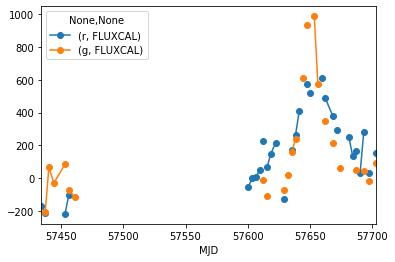

In [186]:
pd.concat(
[  pd.DataFrame(  data_mjd[i]['FLUXCAL'] ) for i in ['r', 'g']], 
    axis = 1, keys = ['r', 'g']
).plot(style='o-')

#### Bazin's fit and derivative 

In [86]:
A = {}
B = {}
t0 = {}
tfall = {}
trise = {}

error_mjd = {}
deriv_mjd = {}
deriv_bazin = {}

for i in  ['r', 'g']:

    [A[i], B[i], t0[i], tfall[i], trise[i]] = fit_scipy( delta_t(data_mjd[i]['FLUXCAL']) , 
                        #data_g_mjd['FLUXCAL'].ewm(2, min_periods=1).mean().values)
                        data_mjd[i]['FLUXCAL'].values)

    
    error_mjd[i] =  data_mjd[i]['FLUXCALERR']
    deriv_mjd[i] =  data_mjd[i]['FLUXCAL'].diff()

    deriv_bazin[i] = np.diff(bazin(delta_t(data_mjd[i]['FLUXCAL']), 
                       A[i], B[i], t0[i], tfall[i], trise[i]) ) 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


In [143]:
i = 'g'

In [144]:
d_baz = pd.DataFrame(deriv_bazin[i], 
                     columns = {'der'}).set_index(delta_t(data_mjd[i]['FLUXCAL'])[:-1] )
flux = pd.DataFrame( {
    'flux' : data_mjd[i]['FLUXCAL'].values, 
    'err' : data_mjd[i]['FLUXCALERR'].values,
    'label' : str(sntype)
                      }   ).set_index(delta_t(data_mjd[i]['FLUXCAL']) )
data_deriv = pd.concat([d_baz, flux ], axis=1 )#


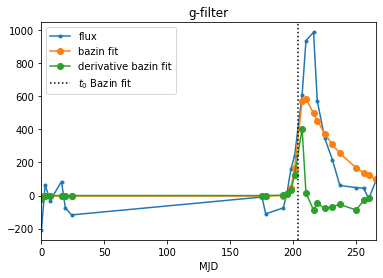

In [196]:
flux['flux'].plot(style='.-', title=str(i)+'-filter')
plt.plot(delta_t(data_mjd[i]['FLUXCAL']), bazin(delta_t(data_mjd[i]['FLUXCAL']), 
                       A[i], B[i], t0[i], tfall[i], trise[i]), 'o-' , label='bazin fit' )

plt.plot(delta_t(data_mjd[i]['FLUXCAL'])[:-1],  np.roll( np.diff( bazin(delta_t(data_mjd[i]['FLUXCAL']), 
                       A[i], B[i], t0[i], tfall[i], trise[i]) ), 1) , 'o-' , label='derivative bazin fit' )

plt.axvline(x=t0[i], linestyle=':', color='k', label='$t_0$ Bazin fit')
plt.legend()

### compare to spline fit 

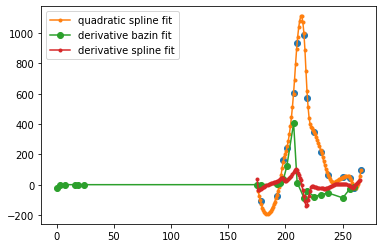

In [216]:

x = flux['flux'][5:].index.values
y = flux['flux'][5:].values
xnew = np.linspace(flux['flux'].index.values[6], x[-1], num=101, endpoint=True)

f2 = interp1d(x, y, kind='quadratic')

plt.plot(x[5:], y[5:], 'o')


plt.plot(xnew, f2(xnew), '.-', label ='quadratic spline fit')

plt.plot(delta_t(data_mjd[i]['FLUXCAL'])[:-1], np.roll( np.diff( bazin(delta_t(data_mjd[i]['FLUXCAL']), 
                       A[i], B[i], t0[i], tfall[i], trise[i]) ), 1),
         'o-',  label ='derivative bazin fit' )

plt.plot( xnew[:-1], np.roll( np.diff(f2(xnew)), 1), '.-',
         label ='derivative spline fit' )

plt.legend()

### detail

(160, 250)

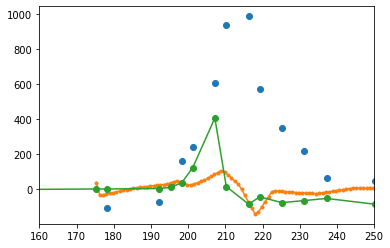

In [214]:
plt.plot(x[5:], y[5:], 'o') 
plt.plot( xnew[:-1], np.roll( np.diff(f2(xnew)), 1), '.-')
plt.plot(delta_t(data_mjd[i]['FLUXCAL'])[5:-1], 
         np.roll( np.diff( bazin(delta_t(data_mjd[i]['FLUXCAL']), 
                       A[i], B[i], t0[i], tfall[i], trise[i]) )[5:], 1), 'o-' )
plt.xlim(160,250)

### Mask the negative derivative part 

In [190]:
## Looking at the opposite limit the negative derivative part 
#data_deriv.mask(d_baz['der'].shift(1) >= 0).dropna().plot(style='o-')

In [159]:
export = data_deriv.mask(d_baz['der'].shift(2)<0)[ 
    ['flux', 'err', 'label' ] ].dropna()

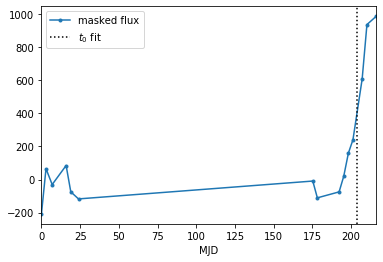

In [221]:
export['flux'].plot(style='.-', label='masked flux')
plt.axvline(x=t0[i], linestyle=':', color='k', label='$t_0$ fit')
plt.legend()

In [177]:
#path_out = path + '/rising_part/'
#file_name_out =  path_out + str(files[index][:-4])+'_rising.dat'
#print(file_name_out)

In [178]:
#export.to_csv(file_name_out, sep='\t')

## Sigmoid fit

In [224]:
prova = export['flux']

In [225]:
prova.tail(1)

MJD
216.283    987.1268
Name: flux, dtype: float64

In [226]:
[aa, bb, cc] = fit_sigmoid( delta_t(prova) ,  prova.values)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [227]:
[aa, bb, cc]

[0.31424007645179053, 205.31512968540906, 1045.6303611131614]

In [228]:
xx = prova.index.values

In [229]:
fsigmoid(xx, aa, bb, cc)


array([9.98761243e-26, 2.50949354e-25, 8.83015462e-25, 1.49506337e-23,
       3.86074197e-23, 1.84596344e-22, 8.35061382e-02, 2.10135708e-01,
       1.71596229e+01, 4.29281524e+01, 1.03548819e+02, 2.26755820e+02,
       6.71735805e+02, 8.63508468e+02, 1.01334958e+03])

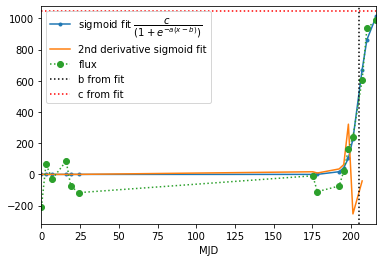

In [239]:
plt.plot(xx, fsigmoid(xx, aa, bb, cc), '.-' , 
         label ='sigmoid fit $\dfrac{c}{(1+e^{-a(x-b)})} $')
plt.plot(xx[:-2], 
         np.diff(np.diff(fsigmoid(xx, aa, bb, cc)) ), label='2nd derivative sigmoid fit' )

prova.plot(style = 'o:', legend='rising data set')
plt.axvline(x=bb, linestyle=':', color='k', label ='b from fit')

plt.axhline(y=cc, linestyle=':', color='red', label ='c from fit')
plt.legend()

### To do next (points discussed with Emille)

* Consider longer classification runs (N =1000 step at least) with current features a, b, c

* in presence of a season gap, like here, neglect all the data before the gap

* Instead of a, b, c pass the whole sigmoid curve to the Random Forest classifier. 
  Possibly also add extra column with Ndays to get from 5% of the max to the max. 